In [1]:
import os
import warnings
import numpy as np
import functions
import pytket
from lambeq import BobcatParser

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
sentence = np.loadtxt('tweets.csv',skiprows=1, delimiter=",", dtype="str", usecols=[0], unpack=True).reshape(-1,1)
score = np.loadtxt('tweets.csv',skiprows=1, delimiter=",", dtype="float", usecols=[1], unpack=True).reshape(-1,1)
dset = np.concatenate((sentence,score),axis=-1)
np.random.shuffle(dset)
sentences = [] 
labels =[]
for i in dset:
    sentences.append(i[0])
    labels.append(i[1])
trainsize = int(np.floor(0.75*np.size(dset)))

train_labels, train_data = labels[0:trainsize], sentences[0:trainsize]
test_labels, test_data = labels[trainsize+1:], sentences[trainsize+1:]

sentence[1]

array(['I love horses'], dtype='<U33')

In [3]:
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Turning parse trees to diagrams.


In [4]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, train_labels)
    if diagram is not None
]

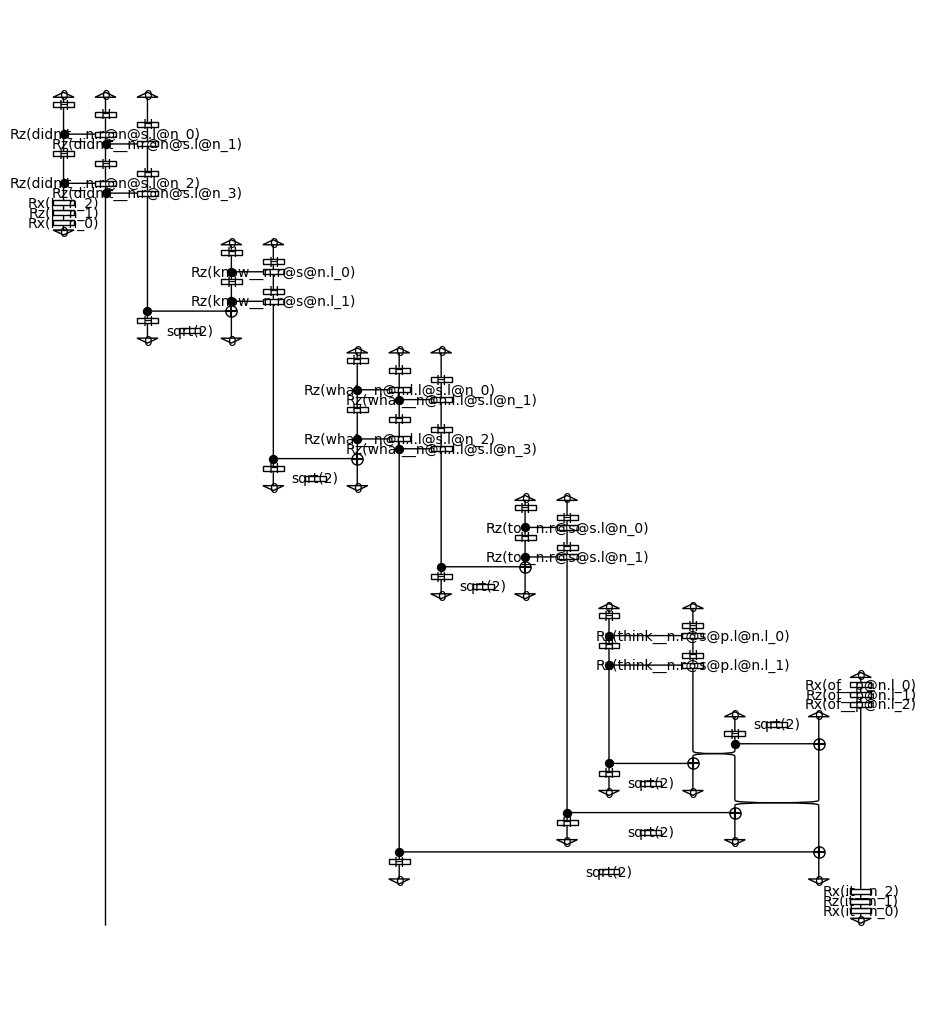

In [5]:
from lambeq import AtomicType, IQPAnsatz, remove_cups
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
PUNC = AtomicType.PUNCTUATION
C = AtomicType.CONJUNCTION

ansatz = IQPAnsatz({N: 1,S: 0, P: 0, PUNC: 0, C: 0},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[2].draw(figsize=(9, 10))


In [6]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)


In [7]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

from lambeq import QuantumTrainer, SPSAOptimizer

BATCH_SIZE = 1
EPOCHS = 1
SEED = 1

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [8]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, test_labels, shuffle=False)

ZeroDivisionError: division by zero